In [ ]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

In [ ]:
df_gt   = pd.read_excel("drive/My Drive/Projects/LSE-Symptomatology/Dataset/Baseline Comparisons/PCOS Symptoms (Groud Truth).xlsx")[['postID', 'PCOS Symptom (Grd Truth)']]
df_chatgpt   = pd.read_excel("drive/My Drive/Projects/LSE-Symptomatology/Dataset/Baseline Comparisons/PCOS Symptoms (ChatGPT-4o).xlsx")[['postID', 'LLM2(GPT 4o)']]
df_lse    = pd.read_excel("drive/My Drive/Projects/LSE-Symptomatology/Dataset/Baseline Comparisons/PCOS Symptoms (LSE).xlsx")[['postID', 'LSE-guided LLM(GPT-4o)']]
df_llama  = pd.read_excel("drive/My Drive/Projects/LSE-Symptomatology/Dataset/Baseline Comparisons/PCOS Symptoms (Llama 3.1).xlsx")[['postID', 'LLM1(Llama-3.1-8B-Instruct)']]
df_google = pd.read_excel("drive/My Drive/Projects/LSE-Symptomatology/Dataset/Baseline Comparisons/PCOS Symptoms (Google Health).xlsx")[['postID', 'GHNLP']]
df_aws    = pd.read_excel("drive/My Drive/Projects/LSE-Symptomatology/Dataset/Baseline Comparisons/PCOS Symptoms (Amazon Comprehend Medical).xlsx")[['postID', 'ACM']]


In [ ]:
df = pd.concat([
    df_gt.set_index('postID'),
    df_chatgpt.set_index('postID'),
    df_lse.set_index('postID'),
    df_llama.set_index('postID'),
    df_google.set_index('postID'),
    df_aws.set_index('postID'),
], axis=1).reset_index()

In [ ]:
#display dataframe
df

,postID,PCOS Symptom (Grd Truth),LLM2(GPT 4o),LSE-guided LLM(GPT-4o),LLM1(Llama-3.1-8B-Instruct),GHNLP,ACM
0,xapb9j,none,none,none,none,none,none
1,va1s9b,weight gain,none,weight gain,"acne, excess hair growth, weight gain, irregul...","losing weight, unhealthy","gaining weight, losing weight, stabilized, unh..."
2,vyv2ut,none,none,none,none,none,none
3,wy5f9k,cysts on overies,cysts on ovaries,cysts on ovaries,cysts on ovaries.,"cysts, follicles","cysts, follicles, regular periods"
4,yvjy63,hair loss,hair loss,hair loss,hair loss.,"balding, hair loss","affecting my mental health, balding, hair loss"
...,...,...,...,...,...,...,...
995,y87em5,"hair loss, weight gain, acne, cramps, insulin ...","hair loss on scalp, weight gain, acne along ja...","hair loss, weight gain, acne, cramps, insulin ...","hair loss on scalp, weight gain, acne along ja...","acne, anxiety, cramps, depression, facial swe...","acne, anxiety, cramps, depression, elevated C..."
996,v96ws6,"irregular periods, weight gain, high blood pre...","irregular periods, weight gain, circulation co...","irregular periods, insulin resistance, weight ...","Weight gain, nausea, lack of appetite, consist...","anxious, concerns, irregular periods, lack of...","affect my fertility, anxious, high BP., insul..."
997,yj6zyi,"hirsutism, acne, irregular periods, painful cr...","excess hair growth, acne, irregular periods, v...","irregular periods, hirsutism, acne, painful pe...","excess hair growth, acne, irregular periods, v...","bloated, constipated, diarrhoea, digestive is...","IBS, acne, bloating, bowel movements, constip..."
998,y6k0n6,"hirsutism, acne,weight gain, low energy, hot f...","weight gain, hirsutism, acne, irregular menstr...","weight gain, hirsutism, acne, irregular period...","hirsutism, acne, hot flashes, low energy, weig...","Hormone irregularity, Hot flashes, acne, anxie...","Hormone irregularity, Hot flashes, Low energy,..."


In [ ]:
# Extract the relevant columns
ground_truth_list = df['PCOS Symptom (Grd Truth)'].tolist()
lse_llm = df['LSE-guided LLM(GPT-4o)'].tolist()
ghnlp_list = df['GHNLP'].tolist()
acm_list = df['ACM'].tolist()
llm_list1 = df['LLM1(Llama-3.1-8B-Instruct)'].tolist()
llm_list2 = df['LLM2(GPT 4o)'].tolist()

In [ ]:
# Store all methods into a dictionary
methods ={
    'LSE-guided LLM(GPT-4o)': lse_llm,
    'GHNLP': ghnlp_list,
    'ACM': acm_list,
    'LLM1(Llama-3.1-8B-Instruct)': llm_list1,
    'LLM2(GPT 4o)': llm_list2
}

In [ ]:
 # Initialize a dictionary to store F1-scores
f1_scores_dict = {method_name: [] for method_name in methods.keys()}

In [ ]:
# Define a similarity threshold
similarity_threshold = 0.6

In [ ]:
# Initialize a dictionary to store results
results_metrics = {}
results_plots={}
results_match={}

In [ ]:
# Load SapBERT model
with open('BioBERT.txt', 'r') as f:
    model_name = f.read().strip()
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
#max_tokens= 500

In [ ]:
# Function to encode symptoms
def get_embeddings(symptom_list, model, tokenizer):
    embeddings = []
    for symptom in symptom_list:
        # Tokenize and encode
        inputs = tokenizer(symptom, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the [CLS] token representation as the embedding
        embeddings.append(outputs.last_hidden_state[:, 0, :])  # Shape: (1, hidden_size)
    return torch.vstack(embeddings)

In [ ]:
def process_duplicates(method_init_symptoms):
    method_init_embeddings = get_embeddings(method_init_symptoms, model, tokenizer).numpy() # Encode all initial symptoms
    method_a_symptoms = set()
    method_a_embeddings = []  # Initialize empty list

    for index, symptom in enumerate(method_init_symptoms):
        if not method_a_symptoms:  # If set is empty, add the first symptom
            method_a_symptoms.add(symptom)
            method_a_embeddings.append(method_init_embeddings[index])
        else:
            is_duplicate = False
            # Compare the symptom's embedding with all embeddings in the non-duplicate set
            for method_a_embedding in method_a_embeddings:
                similarity_scores = cosine_similarity([method_init_embeddings[index]], [method_a_embedding])
                if np.max(similarity_scores) >= 0.8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                method_a_symptoms.add(symptom)
                method_a_embeddings.append(method_init_embeddings[index])

    return list(method_a_symptoms)

In [ ]:
def calculate_metrics(ground_truth, predicted, similarity_threshold):
    correct_matches = 0
    predicted_embeddings = get_embeddings(predicted, model, tokenizer).numpy()
    ground_truth_embeddings = get_embeddings(ground_truth, model, tokenizer).numpy()
    used_ground_truth = set()

    for predicted_embedding in predicted_embeddings:
        similarity_scores = cosine_similarity([predicted_embedding], ground_truth_embeddings)
        max_similarity_score_index = np.argmax(similarity_scores)
        max_similarity_score = similarity_scores[0][max_similarity_score_index]

        if max_similarity_score >= similarity_threshold and max_similarity_score_index not in used_ground_truth:
            correct_matches += 1
            used_ground_truth.add(max_similarity_score_index)

    missed_symptoms = len(ground_truth) - correct_matches
    wrong_matches = len(predicted) - correct_matches

    precision = correct_matches / len(predicted) if len(predicted) > 0 else 0
    recall = correct_matches / len(ground_truth) if len(ground_truth) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score, correct_matches, missed_symptoms, wrong_matches


In [ ]:
# Define the subsets of indices
#index_ranges = [(0, 250), (250, 750), (750, 1000), (0,1000)]  # Define start and end of ranges
index_ranges = [(0, 1000)]
similarity_threshold = 0.8  # set threshold to a range [0.4, 0.6, 0.8]

# Iterate through each index range
for start_idx, end_idx in index_ranges:
    # Slice the DataFrame for the current range
    subset_df = df.iloc[start_idx:end_idx]

    ground_truth_list = subset_df['PCOS Symptom (Grd Truth)'].tolist()
    lse_llm = subset_df['LSE-guided LLM(GPT-4o)'].tolist()
    ghnlp_list = subset_df['GHNLP'].tolist()
    acm_list = subset_df['ACM'].tolist()
    llm_list1 = subset_df['LLM1(Llama-3.1-8B-Instruct)'].tolist()
    llm_list2 = subset_df['LLM2(GPT 4o)'].tolist()

    methods = {
    'LSE-guided LLM(GPT-4o)': lse_llm,
    'GHNLP': ghnlp_list,
    'ACM': acm_list,
    'LLM1(Llama-3.1-8B-Instruct)': llm_list1,
    'LLM2(ChatGPT 4o)': llm_list2
    }
    # Initialize a dictionary to store F1-scores
    f1_scores_dict = {method_name: [] for method_name in methods.keys()}

    # Iterate through each method
    for method_name, method_list in methods.items():
        precision_list = []
        recall_list = []
        f1_score_list = []
        correct_match_list = []
        missed_list = []
        wrong_match_list = []

        # Iterate through rows in the subset
        for index, (ground_truth, predicted) in enumerate(zip(ground_truth_list, method_list)):
            # Ensure ground_truth and predicted are strings, otherwise handle NaN values
            ground_truth = str(ground_truth) if not pd.isna(ground_truth) else ""
            predicted = str(predicted) if not pd.isna(predicted) else ""

            # Split the symptoms by comma and strip any leading/trailing whitespace
            ground_truth_symptoms = [symptom.strip().lower().replace('.', '')  for symptom in ground_truth.split(',') if symptom.strip()]
            predicted_symptoms = [symptom.strip().lower().replace('.', '') for symptom in predicted.split(',') if symptom.strip()]

            # If the method is Google health or ACM, process duplicates first
            if method_name in ['GHNLP', 'ACM']:
              predicted_symptoms = process_duplicates(predicted_symptoms)

            # Skip rows where either ground truth or predicted list is empty
            if not ground_truth_symptoms or not predicted_symptoms:
                continue

            # Calculate precision, recall, and f1-score for this row
            precision, recall, f1_score, correct_matches, missed_symptoms, wrong_matches = calculate_metrics(
                ground_truth_symptoms, predicted_symptoms, similarity_threshold
            )

            # Append the F1-score to the list
            f1_scores_dict[method_name].append(f1_score)

            # Append the results
            precision_list.append(precision)
            recall_list.append(recall)
            f1_score_list.append(f1_score)

            correct_match_list.append(correct_matches)
            missed_list.append(missed_symptoms)
            wrong_match_list.append(wrong_matches)

        # Store the average results for this method within this subset
        results_metrics[method_name] = {
            'Average Precision': np.mean(precision_list),
            'Average Recall': np.mean(recall_list),
            'Average F1-Score': np.mean(f1_score_list)
        }

        results_match[method_name] = {
        'Correctly Identified': sum(correct_match_list),
        'Not Identified': sum(missed_list),
        'Incorrectly Identified': sum(wrong_match_list)
    }


    # Optionally, print or save results for this subset
    print(f"Processed rows {start_idx} to {end_idx}\n")
    results_dataframe = pd.DataFrame(results_metrics).T
    # Display the results
    print(results_dataframe)

    results_dataframe1 = pd.DataFrame(results_match).T

    # Display the results
    print(results_dataframe1)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Processed rows 0 to 1000

                             Average Precision  Average Recall  \
LSE-guided LLM(GPT-4o)                0.832301        0.828113   
GHNLP                                 0.281560        0.363887   
ACM                                   0.244161        0.490157   
LLM1(Llama-3.1-8B-Instruct)           0.408003        0.502108   
LLM2(ChatGPT 4o)                      0.551331        0.507994   

                             Average F1-Score  
LSE-guided LLM(GPT-4o)               0.819965  
GHNLP                                0.298873  
ACM                                  0.303863  
LLM1(Llama-3.1-8B-Instruct)          0.427114  
LLM2(ChatGPT 4o)                     0.516058  
                             Correctly Identified  Not Identified  \
LSE-guided LLM(GPT-4o)                       2653             471   
GHNLP                                        1180            1944   
ACM                                          1635            1489   
LLM1(Llama-3.

In [ ]:
# Process each method
for method_name, method_list in methods.items():
    precision_list = []
    recall_list = []
    f1_score_list = []
    correct_match_list = []
    missed_list = []
    wrong_match_list = []

    for index, (ground_truth, predicted) in enumerate(zip(ground_truth_list, method_list)):
        # Ensure ground_truth and predicted are strings, otherwise handle NaN values
        ground_truth = str(ground_truth) if not pd.isna(ground_truth) else ""
        predicted = str(predicted) if not pd.isna(predicted) else ""

        # Split the symptoms by comma and strip any leading/trailing whitespace
        ground_truth_symptoms = [symptom.strip().lower() for symptom in ground_truth.split(',') if symptom.strip()]
        predicted_symptoms = [symptom.strip().lower() for symptom in predicted.split(',') if symptom.strip()]

        # If the method is Google health or ACM, process duplicates first
        if method_name == 'GHNLP' or method_name == 'ACM':
            predicted_symptoms = process_duplicates(predicted_symptoms)

        # Skip rows where either ground truth or predicted list is empty
        if not ground_truth_symptoms or not predicted_symptoms:
            continue

        # Calculate precision, recall, and f1-score for this row
        precision, recall, f1_score, correct_matches, missed_symptoms, wrong_matches = calculate_metrics(ground_truth_symptoms, predicted_symptoms)

        # Append the F1-score to the list
        f1_scores_dict[method_name].append(f1_score)


        # Append the results
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)

        correct_match_list.append(correct_matches)
        missed_list.append(missed_symptoms)
        wrong_match_list.append(wrong_matches)

    # Store the average results for this method
    results_metrics[method_name] = {
        'Average Precision': np.mean(precision_list),
        'Average Recall': np.mean(recall_list),
        'Average F1-Score': np.mean(f1_score_list)
    }

    results_plots[method_name] = {
        'Average Correct Matches': np.mean(correct_match_list),
        'Average Missed Symptoms': np.mean(missed_list),
        'Average Wrong Matches': np.mean(wrong_match_list)
    }

    results_match[method_name] = {
        'Correct Matches': sum(correct_match_list),
        'Missed Symptoms': sum(missed_list),
        'Wrong Matches': sum(wrong_match_list)
    }


**post Length 100-300**

In [ ]:
# Convert the results to a DataFrame and display #0.6 threshold
results_dataframe = pd.DataFrame(results_metrics).T

# Display the results
print(results_dataframe)

                        Average Precision  Average Recall  Average F1-Score
LSE-guided LLM(GPT-4o)           0.866495        0.874236          0.857847
GHNLP                            0.426193        0.482064          0.421158
ACM                              0.410806        0.720057          0.493360
LLM2(ChatGPT 4o)                 0.721088        0.688591          0.685771


**post Length 300-600**

In [ ]:
# Convert the results to a DataFrame and display #0.6 threshold
results_dataframe = pd.DataFrame(results_metrics).T

# Display the results
print(results_dataframe)

                        Average Precision  Average Recall  Average F1-Score
LSE-guided LLM(GPT-4o)           0.912031        0.895794          0.894249
GHNLP                            0.459843        0.525080          0.465639
ACM                              0.460718        0.725956          0.542544
LLM2(ChatGPT 4o)                 0.781185        0.668588          0.701834


**Entire TestData_1000**

In [ ]:
# Convert the results to a DataFrame and display #0.6 threshold
results_dataframe = pd.DataFrame(results_metrics).T

# Display the results
print(results_dataframe)

                        Average Precision  Average Recall  Average F1-Score
LSE-guided LLM(GPT-4o)           0.876103        0.872465          0.863250
GHNLP                            0.459094        0.502235          0.452928
ACM                              0.460048        0.712527          0.529838
LLM2(ChatGPT 4o)                 0.701998        0.648612          0.656716


In [ ]:
# Convert the results to a DataFrame and display #0.6 threshold
results_dataframe = pd.DataFrame(results_metrics).T

# Display the results
print(results_dataframe)

                             Average Precision  Average Recall  \
LSE-guided LLM(GPT-4o)                0.876103        0.872465   
GHNLP                                 0.459094        0.502235   
ACM                                   0.460048        0.712527   
LLM1(Llama-3.1-8B-Instruct)           0.541846        0.678112   
LLM2(GPT 4o)                          0.701891        0.648666   

                             Average F1-Score  
LSE-guided LLM(GPT-4o)               0.863250  
GHNLP                                0.452928  
ACM                                  0.529838  
LLM1(Llama-3.1-8B-Instruct)          0.569900  
LLM2(GPT 4o)                         0.656746  


In [ ]:
# Prepare data for plotting
correct_matches = [results_match[model]['Correct Matches'] for model in methods.keys()]
missed_symptoms = [results_match[model]['Missed Symptoms'] for model in methods.keys()]
wrong_matches = [results_match[model]['Wrong Matches'] for model in methods.keys()]


In [ ]:
r = np.arange(len(methods))
bar_width = 0.3


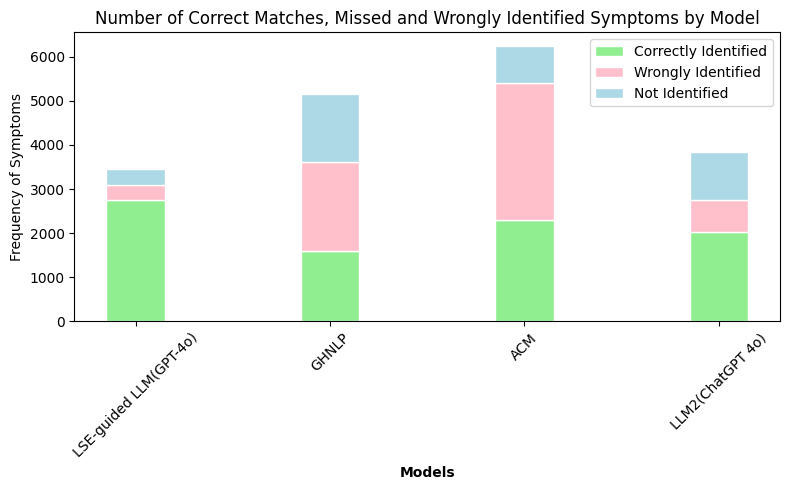

In [ ]:
# Stacked bar plot
plt.figure(figsize=(8, 5))
plt.bar(r, correct_matches, color='lightgreen', edgecolor='white', width=bar_width, label='Correctly Identified')
plt.bar(r, wrong_matches, bottom=correct_matches, color='pink', edgecolor='white', width=bar_width, label='Wrongly Identified')
plt.bar(r, missed_symptoms, bottom=[i+j for i,j in zip(correct_matches, wrong_matches)], color='lightblue', edgecolor='white', width=bar_width, label='Not Identified')
# Add labels
plt.xlabel('Models', fontweight='bold')
plt.xticks(r, methods.keys(), rotation=45)
plt.ylabel('Frequency of Symptoms')
plt.title('Number of Correct Matches, Missed and Wrongly Identified Symptoms by Model')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Function to count the number of symptoms in a list
def count_symptoms(symptom_list):
    return len([symptom.strip().lower() for symptom in str(symptom_list).split(',') if symptom.strip()])

# Calculate the number of symptoms for each method
predicted_symptom_counts = {}
ground_truth_counts = [count_symptoms(symptom_list) for symptom_list in ground_truth_list]

# For each predicted method, count the number of symptoms
for method_name, method_list in methods.items():
    predicted_symptom_counts[method_name] = [count_symptoms(symptom_list) for symptom_list in method_list]

# Calculate average and standard deviation for each method
for method_name, counts in predicted_symptom_counts.items():
    avg_predicted = np.mean(counts)
    std_predicted = np.std(counts)
    print(f"Method: {method_name} - Average Predicted Symptoms: {avg_predicted:.2f}, Standard Deviation: {std_predicted:.2f}")

# Calculate average and standard deviation for the ground truth
avg_ground_truth = np.mean(ground_truth_counts)
std_ground_truth = np.std(ground_truth_counts)
print(f"Ground Truth - Average Symptoms: {avg_ground_truth:.2f}, Standard Deviation: {std_ground_truth:.2f}")


Method: LSE-guided LLM(GPT-4o) - Average Predicted Symptoms: 3.09, Standard Deviation: 2.18
Method: GHNLP - Average Predicted Symptoms: 4.84, Standard Deviation: 4.03
Method: ACM - Average Predicted Symptoms: 9.05, Standard Deviation: 6.97
Method: LLM1(Llama-3.1-8B-Instruct) - Average Predicted Symptoms: 4.19, Standard Deviation: 2.45
Method: LLM2(GPT 4o) - Average Predicted Symptoms: 2.76, Standard Deviation: 2.18
Ground Truth - Average Symptoms: 3.13, Standard Deviation: 2.28
